<a href="https://colab.research.google.com/github/Fugant1/AnalyPrevMilk/blob/main/AnaliseLeite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importação das bibliotecas utilizadas nessa análise e previsão de dados

In [368]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Importação dos dados fornecidos pela empresa

In [356]:
df = pd.read_excel("/Desafio_Inteligência de Dados_MilkPoint.xlsx", header=3) #Import dataset
df = df.loc[:, ~df.columns.str.contains('^Unnamed')] #Remoção das colunas vazias

In [357]:
print(df.columns) #visualização para ver se o header esta correto

Index(['Mês', 'Produção de Leite (milhões/l)', 'Importações (milhões/l)',
       'Exportações (milhões/l)', 'Oferta Total (milhões de litros)',
       'População (milhões de pessoas)', 'Oferta Per Capita (litros/mês)',
       'Taxa de Desemprego %)', 'Massa Salarial (mihões de reais)',
       'Leite UHT Indústria (R$/litro)', 'Leite UHT Supermercado (R$/litro)',
       'Preço do Leite ao Produtor (R$/litro)'],
      dtype='object')


# Tratamento do dataset

Alternativa 1 - Remoção total das linhas com valores NaN

Vantagem: Mantém a integridade dos dados (não cria viés)

Desvantagem: Recorta uma parte da análise

Optei pela alterantiva 1 já que a segunda inviesou os dados completamente

In [358]:
df_cleaned = df.dropna(axis=0, thresh=0.05*len(df)) #Aqui removi as linhas com valores em falta para que a análise não seja prejudicada

In [359]:
print(df_cleaned.describe())

                       Mês  Produção de Leite (milhões/l)  \
count                  125                     125.000000   
mean   2019-10-01 08:38:24                    2049.753944   
min    2014-08-01 00:00:00                    1728.491000   
25%    2017-03-01 00:00:00                    1948.902000   
50%    2019-10-01 00:00:00                    2067.336000   
75%    2022-05-01 00:00:00                    2140.711000   
max    2024-12-01 00:00:00                    2348.481000   
std                    NaN                     136.256036   

       Importações (milhões/l)  Exportações (milhões/l)  \
count               125.000000               125.000000   
mean                119.976497                13.183627   
min                  42.017019                 2.414308   
25%                  77.301653                 5.616580   
50%                 102.601614                 7.604574   
75%                 166.996422                16.511187   
max                 244.038934       

Alternativa 2 - Preenchimento dos dados com valores como média, mediana, moda

Vantagem: Mantém o volume dos dados

Desvantagem: Pode inviesar, já que os valores não são reais

Optei pela média pela ausência de outliers significativos

In [ ]:
df_cleaned = df.fillna(df.mean())

In [ ]:
print(df_cleaned.describe())

                                 Mês  Produção de Leite (milhões/l)  \
count                            228                     228.000000   
mean   2016-06-16 02:06:18.947368448                    1936.686436   
min              2007-01-01 00:00:00                    1324.948000   
25%              2011-09-23 12:00:00                    1775.553250   
50%              2016-06-16 00:00:00                    1968.410500   
75%              2021-03-08 18:00:00                    2110.754000   
max              2025-12-01 00:00:00                    2348.481000   
std                              NaN                     224.970512   

       Importações (milhões/l)  Exportações (milhões/l)  \
count               228.000000               228.000000   
mean                100.998968                20.305653   
min                  10.188356                 2.414308   
25%                  63.554174                 6.574744   
50%                  87.215257                10.121270   
75%   

# Análise dos dados

Matriz correlação

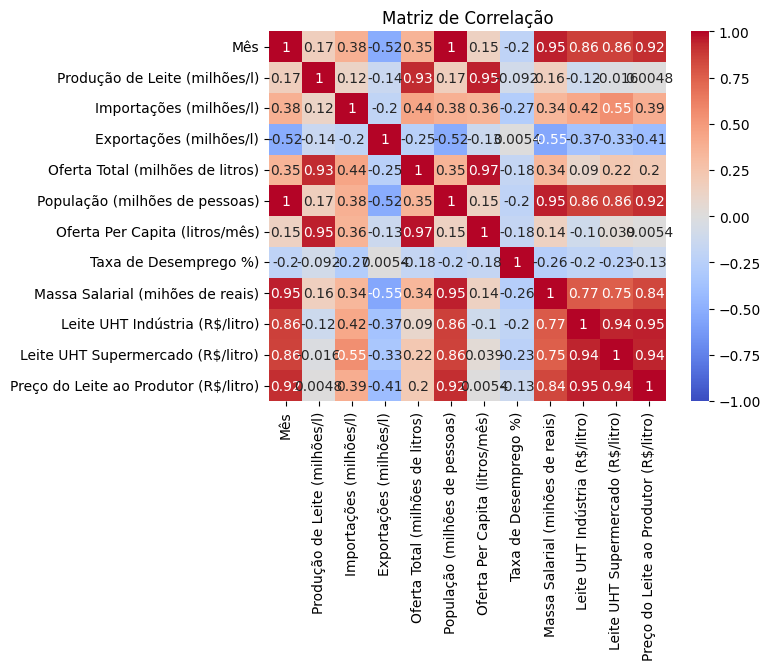

In [361]:
correlacao = df_cleaned.corr(method='spearman') #coloquei o método spearman pela grande variabilidade dos dados, pois não são completamente lineares
sns.heatmap(correlacao, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlação')
plt.show()

In [362]:
correlacao_target = correlacao[['Preço do Leite ao Produtor (R$/litro)']].sort_values(by='Preço do Leite ao Produtor (R$/litro)', ascending=False)
print(correlacao_target)

                                       Preço do Leite ao Produtor (R$/litro)
Preço do Leite ao Produtor (R$/litro)                               1.000000
Leite UHT Indústria (R$/litro)                                      0.951306
Leite UHT Supermercado (R$/litro)                                   0.942968
Mês                                                                 0.919287
População (milhões de pessoas)                                      0.919287
Massa Salarial (mihões de reais)                                    0.841253
Importações (milhões/l)                                             0.394697
Oferta Total (milhões de litros)                                    0.204916
Oferta Per Capita (litros/mês)                                      0.005358
Produção de Leite (milhões/l)                                       0.004842
Taxa de Desemprego %)                                              -0.127758
Exportações (milhões/l)                                            -0.407705

Relação Preço x Demanda

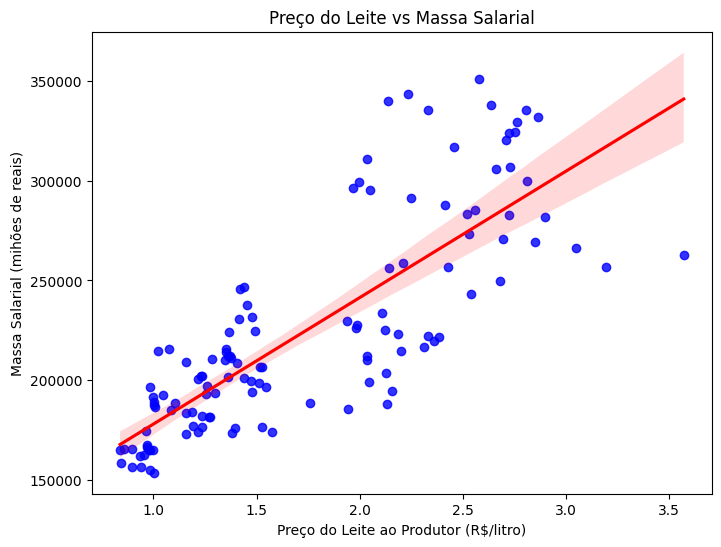

In [395]:
plt.figure(figsize=(8, 6))
sns.regplot(x='Preço do Leite ao Produtor (R$/litro)', y='Massa Salarial (mihões de reais)', data=df_cleaned, scatter_kws={'color':'blue'}, line_kws={'color':'red'})
plt.title('Preço do Leite vs Massa Salarial')
plt.xlabel('Preço do Leite ao Produtor (R$/litro)')
plt.ylabel('Massa Salarial (mihões de reais)')
plt.show()

#Relação da variável alvo com a massa salarial, observa-se um crescimento em conjunto com o preço

Identificação de padrões e tendências mais complexas com séries temporáis

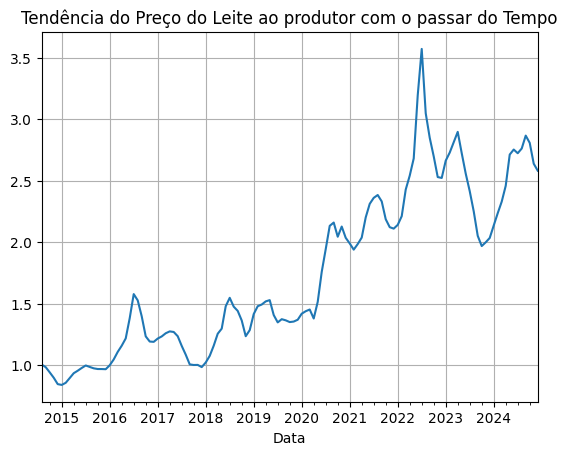

In [363]:
df_cleaned = df_cleaned.copy() #certificar que é uma cópia para evitar warnings
df_cleaned['Data'] = pd.to_datetime(df['Mês'])

df_temporal = df_cleaned.set_index('Data')
df_temporal['Preço do Leite ao Produtor (R$/litro)'].plot()
plt.title('Tendência do Preço do Leite ao produtor com o passar do Tempo')
plt.grid(True)
plt.show()

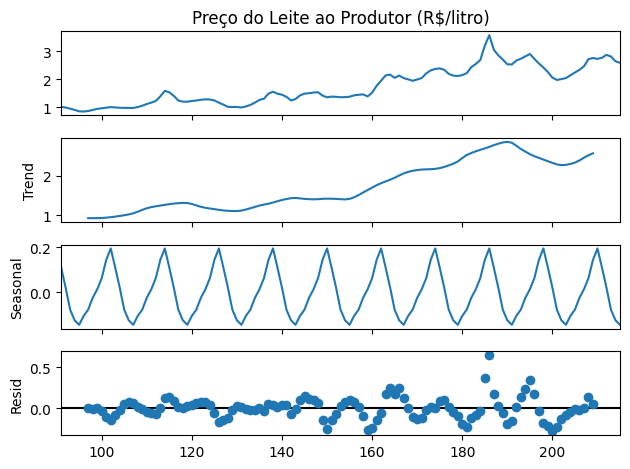

In [392]:
decomposicao = seasonal_decompose(df_cleaned['Preço do Leite ao Produtor (R$/litro)'], period=12, model='addtive')
decomposicao.plot()
plt.show()
#aqui observamos muitos resíduos, o que indica que a sazonalidade e a tendência não
#conseguem explicar muitos valores, portanto existem muitas variações irregulares e a "aleatórias"

Padronização dos dados

In [365]:
scaler = StandardScaler() #alterar a escala para que haja padronização na unidade dos dados, clusters são sensíveis a dados com grande diferença de escala
df_numeric = df_cleaned.select_dtypes(include=['float64', 'int64']) #ajuste dos tipos de dados para que possam ser todos numéricos
df_scaled = scaler.fit_transform(df_numeric)

In [366]:
pca = PCA(n_components=3) #aqui aplicamos o pca para que hajam menos variáveis ao clusterizar, reduzindo de 11 para 3
df_pca = pca.fit_transform(df_scaled)

Análise por clusterização

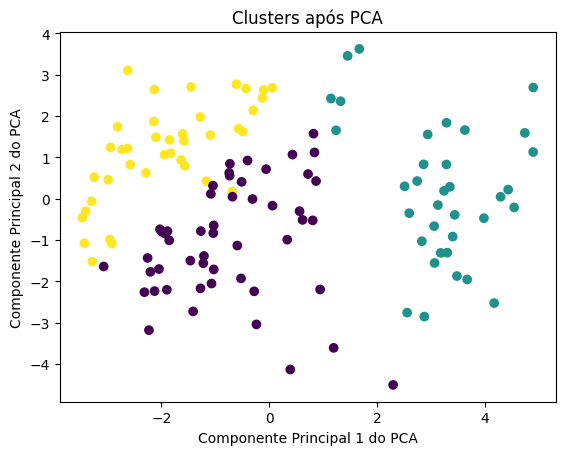

,Mês,Produção de Leite (milhões/l),Importações (milhões/l),Exportações (milhões/l),Oferta Total (milhões de litros),População (milhões de pessoas),Oferta Per Capita (litros/mês),Taxa de Desemprego %),Massa Salarial (mihões de reais),Leite UHT Indústria (R$/litro),Leite UHT Supermercado (R$/litro),Preço do Leite ao Produtor (R$/litro),Data
Cluster,,,,,,,,,,,,,
0,2019-07-27 14:07:03.529411840,1973.708784,93.377347,10.189645,2056.896486,207.763277,9.899177,0.124863,210926.921569,2.933592,3.405218,1.700797,2019-07-27 14:07:03.529411840
1,2023-04-19 04:48:00.000000000,2101.434057,179.752833,6.930679,2274.256210,211.545716,10.751542,0.086629,291302.857143,4.063840,4.863874,2.504263,2023-04-19 04:48:00.000000000
2,2016-10-19 10:27:41.538461440,2102.818026,101.114572,22.710452,2181.222145,204.182281,10.679537,0.101769,182970.923077,2.032176,2.802672,1.096274,2016-10-19 10:27:41.538461440


In [400]:
kmeans = KMeans(n_clusters=3, random_state=42) #escolhi 3 como número de clusters após usar o Elbow Method e verificar que algo próximo de 3 seria o ideal
clusters = kmeans.fit_predict(df_pca)

df_cleaned = df_cleaned.copy() #aqui houve a adição dos clusters no dataframe de modo que o kmeans tenha certeza que isso é uma copia do dataset, assim ele não dá warning
df_cleaned.loc[:, 'Cluster'] = kmeans.fit_predict(df_pca)

plt.scatter(df_pca[:, 0], df_pca[:, 1], c=clusters, cmap='viridis') #visualização dos clusters em gráfico
plt.xlabel("Componente Principal 1 do PCA")
plt.ylabel("Componente Principal 2 do PCA")
plt.title("Clusters após PCA")
plt.show()

display(df_cleaned.groupby('Cluster').mean()) #visualização dos dados dos clusters, 3 principais períodos do leite no Brasil dentro dessa época e dados fornecidos

# Previsão de preço do leite ao produtor até o final de 2025

Separação das variáveis alvo e teste

In [416]:
df['Data'] = pd.to_datetime(df['Mês'])
df_tpredict = df.copy()

df_tpredict['Ano'] = df_tpredict['Data'].dt.year
df_tpredict['Mês'] = df_tpredict['Data'].dt.month
#converti as colunas para não dar problema com dtype no train_split

In [418]:
df_tpredict = df_tpredict.iloc[4:215].reset_index(drop=True) #setando os dados para análise de 2007~2024
df_tpredict['Tendência'] = range(1, len(df_tpredict) + 1) #aqui criamos uma variável de tendência para registrar a passagem de tempo
df_tpredict['Mês_Categórico'] = df_tpredict['Mês'].astype('category') #tentativa de registrar meses em que há alta ou baixa

x = df_tpredict[['Ano', 'Mês', 'Tendência', 'Mês_Categórico', 'Produção de Leite (milhões/l)', 'Importações (milhões/l)',
                'Exportações (milhões/l)', 'Oferta Total (milhões de litros)',
                'População (milhões de pessoas)', 'Oferta Per Capita (litros/mês)']] #Aqui utilizei todos os indicadores disponíveis para o treinamento da IA para maior acuracia

y = df_tpredict['Preço do Leite ao Produtor (R$/litro)'] #valores que queremos fazer a projeção

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=42) #split entre teste e treino

Método com Regressão Linear - Não apresentou resultados aceitáveis

In [419]:
modelo_LR = LinearRegression()

modelo_LR.fit(x_train, y_train)

y_pred = modelo_LR.predict(x_test)

In [420]:
#teste para verificar overfiting e desempenho do modelo com base no erro
y_pred_train = modelo_LR.predict(x_train)
r2_train = r2_score(y_train, y_pred_train)
rmse_train = mean_squared_error(y_train, y_pred_train)

y_pred_test = modelo_LR.predict(x_test)
r2_test = r2_score(y_test, y_pred_test)
rmse_test = mean_squared_error(y_test, y_pred_test)

print(f'R² no treino: {r2_train}')
print(f'R² no teste: {r2_test}')
print(f'RMSE no treino: {rmse_train}')
print(f'RMSE no teste: {rmse_test}')
#utilizando regressão linear consegui um R² de ~0.901 o que não reflete uma boa precisão

R² no treino: 0.906619520681284
R² no teste: 0.8921423461098024
RMSE no treino: 0.046539767122679696
RMSE no teste: 0.05181589008483342


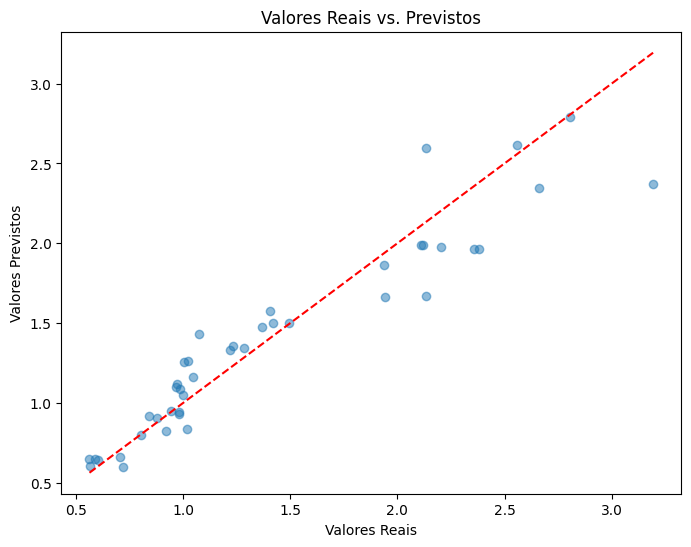

In [421]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Linha de referência
plt.title('Valores Reais vs. Previstos')
plt.xlabel('Valores Reais')
plt.ylabel('Valores Previstos')
plt.show()

Método com RandomForest

In [422]:
modelo_RF = RandomForestRegressor(n_estimators=220, random_state=42) #220 foi testado como o melhor em um range de 0~300

modelo_RF.fit(x_train, y_train)

y_pred = modelo_RF.predict(x_test)

In [423]:
#novamente teste para verificar overfiting e desempenho do modelo
y_pred_train = modelo_RF.predict(x_train)
r2_train = r2_score(y_train, y_pred_train)
rmse_train = mean_squared_error(y_train, y_pred_train)

y_pred_test = modelo_RF.predict(x_test)
r2_test = r2_score(y_test, y_pred_test)
rmse_test = mean_squared_error(y_test, y_pred_test)

print(f'R² no treino: {r2_train}')
print(f'R² no teste: {r2_test}')
print(f'RMSE no treino: {rmse_train}')
print(f'RMSE no teste: {rmse_test}')
#observa-se um resultado muito mais satisfatório com o método random forest, com um R² ~0.993 no treino e de ~0.963 no teste
#isso pode ser explicado pela simplificação do modelo anterior, o que pode subestimar os valores, que não são tão lineares quanto parecem

R² no treino: 0.9949087564646273
R² no teste: 0.9620712691496868
RMSE no treino: 0.0025374177797094027
RMSE no teste: 0.018221339681630845


Previsão completa com o modelo mais adequado

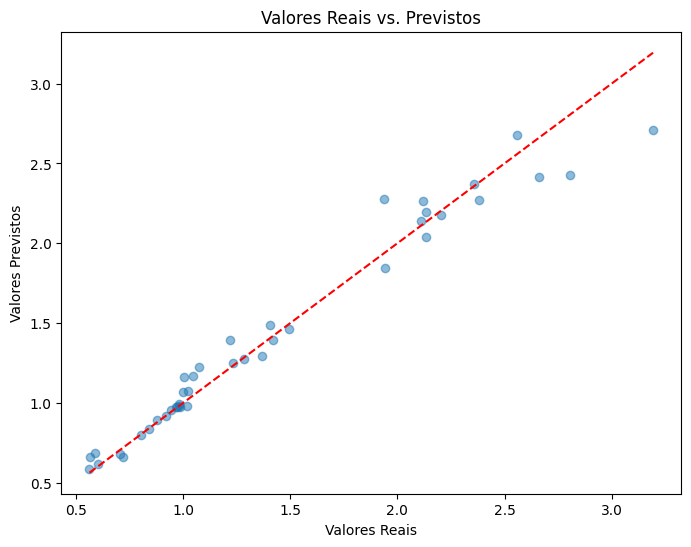

In [424]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Linha de referência
plt.title('Valores Reais vs. Previstos')
plt.xlabel('Valores Reais')
plt.ylabel('Valores Previstos')
plt.show()

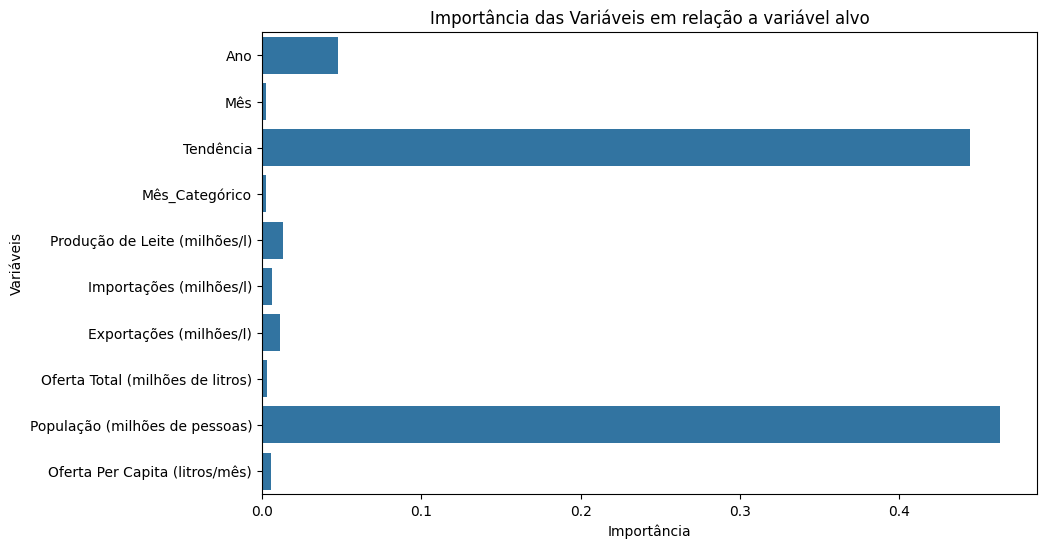

In [425]:
# Medição da importância das variáveis na variável alvo
importancias = modelo_RF.feature_importances_

plt.figure(figsize=(10, 6))
sns.barplot(x=importancias, y=x_train.columns)
plt.title('Importância das Variáveis em relação a variável alvo')
plt.xlabel('Importância')
plt.ylabel('Variáveis')
plt.show()

#performou como o esperado da matriz corr com a tendência(passar do tempo) e
#população como as variáveis mais impactantes de oferta

In [426]:
dados_futuros = {
    'Ano': [2025, 2025, 2025, 2025, 2025, 2025, 2025, 2025, 2025, 2025, 2025, 2025],
    'Mês':[1,2,3,4,5,6,7,8,9,10,11,12],
    'Tendência': range(len(df) + 1, len(df) + len(df_futuro) + 1),
    'Mês_Categórico': df_futuro['Mês'].astype('category'),
    'Produção de Leite (milhões/l)': df['Produção de Leite (milhões/l)'].iloc[216:228],  #esses índices estão assim porque a tabela vai de 5-232
    'Importações (milhões/l)': df['Importações (milhões/l)'].iloc[216:228],
    'Exportações (milhões/l)': df['Exportações (milhões/l)'].iloc[216:228],
    'Oferta Total (milhões de litros)': df['Oferta Total (milhões de litros)'].iloc[216:228],
    'População (milhões de pessoas)': df['População (milhões de pessoas)'].iloc[216:228],
    'Oferta Per Capita (litros/mês)': df['Oferta Per Capita (litros/mês)'].iloc[216:228]
}

df_futuro = pd.DataFrame(dados_futuros)
#aqui criei um dataframe com os valores da planilha de 2025 para fazer a previsão do preço do leite ao produtor

In [427]:
previsoes = modelo_RF.predict(df_futuro)
df_futuro['Preço do Leite ao Produtor (R$/litro)'] = previsoes

In [428]:
df_futuro.drop(columns=['Tendência','Mês_Categórico','Produção de Leite (milhões/l)','Importações (milhões/l)','Exportações (milhões/l)',
                        'Oferta Total (milhões de litros)','População (milhões de pessoas)',
                        'Oferta Per Capita (litros/mês)'], inplace=True)
#removi as colunas que para que fique mais visual o resultado das previsões

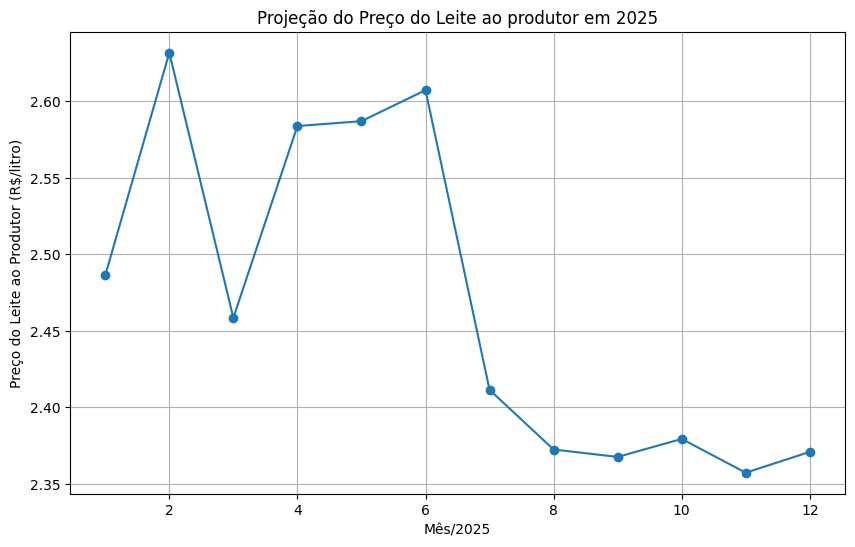

In [429]:
plt.figure(figsize=(10, 6))
plt.plot(df_futuro['Mês'], df_futuro['Preço do Leite ao Produtor (R$/litro)'], marker='o')
plt.title('Projeção do Preço do Leite ao produtor em 2025')
plt.xlabel('Mês/2025')
plt.ylabel('Preço do Leite ao Produtor (R$/litro)')
plt.grid(True)
plt.show()

In [430]:
display(df_futuro)

,Ano,Mês,Preço do Leite ao Produtor (R$/litro)
216,2025,1,2.486174
217,2025,2,2.631730
218,2025,3,2.458448
219,2025,4,2.583796
220,2025,5,2.587001
221,2025,6,2.607263
222,2025,7,2.411376
223,2025,8,2.372368
224,2025,9,2.367538
225,2025,10,2.379292
